In [192]:
from sqlalchemy import create_engine
import pandas as pd

from pandas.tseries.holiday import *
from pandas.tseries.holiday import Holiday, sunday_to_monday, Easter, Day
from pandas.tseries.offsets import CustomBusinessDay

In [193]:
user = "schedulin"
passw = "MySQLIsFun"
host = "35.231.228.133"
database = "schedulin"

In [194]:
db = create_engine(
    'mysql+pymysql://{0}:{1}@{2}/{3}' \
        .format(user, passw, host, database), \
    connect_args = {'connect_timeout': 10})
conn = db.connect()

In [195]:
timetable_df = pd.read_sql_table(
    "timetable",
    con = conn)
resource_df = pd.read_sql_table(
    "resource",
    con = conn)
user_df = pd.read_sql_table(
    "user",
    con = conn)
reservation_df = pd.read_sql_table(
    "reservation",
    con = conn)

In [196]:
merge_1_df = resource_df.merge(timetable_df, left_on = "timetable_id", right_on = "id", suffixes=["_res", "_tim"])\
    .drop(axis = 1, columns = [
        "creation_date_res", "modification_date_res", "id_tim"])\
    .rename(columns={"id_res": "resource_id"})

In [197]:
merge_2_df = reservation_df.merge(user_df, left_on = "user_id", right_on = "id", suffixes=["_rva", "_use"])\
    .drop(axis = 1, columns = [
        "creation_date_rva", "modification_date_rva",
        "creation_date_use", "modification_date_use", "id_use"])\
    .rename(columns={"id_rva": "reservation_id"})

In [198]:
merge_3_df = merge_2_df.merge(merge_1_df, on = "resource_id",
                    suffixes = ["_rva", ""])\
    .drop(axis = 1, columns = [
        "deletion_date_rva", "deletion_date_res",
        "deletion_date_tim"])

In [199]:
import numpy as np

merge_3_df["is_legit"] = np.select([
    merge_3_df["date"] > \
        merge_3_df["deletion_date_use"]],
    [False],
    default = True
)

In [200]:
model_df = merge_3_df.groupby(["date"]).sum()[["is_legit"]].reset_index()
model_df

,date,is_legit
0,2012-11-04,11
1,2012-11-05,6
2,2012-11-06,7
3,2012-11-07,6
4,2012-11-08,11
...,...,...
3648,2022-10-31,49
3649,2022-11-01,56
3650,2022-11-02,51
3651,2022-11-03,56


In [201]:
model_df["day_of_week"] = model_df["date"].dt.day_name()
model_df["month"] = model_df["date"].dt.month_name()

In [202]:
def convert_to_season(column):
    if column in ["January","February","December"]:
        return "Winter"
    elif column in ["March","April","May"]:
        return "Spring"
    elif column in ["June","July","August"]:
        return "Summer"
    else:
        return "Autumn"

In [203]:
model_df["season"] = model_df["month"].apply(convert_to_season)

In [204]:
model_df["week_day"] = model_df["day_of_week"].apply(lambda x: "weekday" if x == "Monday" or x == "Tuesday"
                                                        or x == "Wednesday" or x == "Thursday" or x == "Friday"
                                                        else "weekend")

In [205]:
model_df.head()

,date,is_legit,day_of_week,month,season,week_day
0,2012-11-04,11,Sunday,November,Autumn,weekend
1,2012-11-05,6,Monday,November,Autumn,weekday
2,2012-11-06,7,Tuesday,November,Autumn,weekday
3,2012-11-07,6,Wednesday,November,Autumn,weekday
4,2012-11-08,11,Thursday,November,Autumn,weekday


In [206]:
import pandas as pd
df = pd.read_csv("temperature.csv")

In [207]:
df

,Unnamed: 0,time,apparent_temperature_max (°C),precipitation_sum (mm)
0,335,2012-12-01,3.3,0.0
1,336,2012-12-02,5.7,0.0
2,337,2012-12-03,7.3,0.0
3,338,2012-12-04,8.5,0.0
4,339,2012-12-05,6.0,0.0
...,...,...,...,...
3507,3842,2022-07-09,37.5,0.0
3508,3843,2022-07-10,38.4,0.0
3509,3844,2022-07-11,38.1,0.6
3510,3845,2022-07-12,37.7,0.0


In [208]:
df["time"] = pd.to_datetime(df["time"])

In [209]:
merge = model_df.merge(df, right_on="time", left_on="date")

In [210]:
merge.head()

,date,is_legit,day_of_week,month,season,week_day,Unnamed: 0,time,apparent_temperature_max (°C),precipitation_sum (mm)
0,2012-12-01,26,Saturday,December,Winter,weekend,335,2012-12-01,3.3,0.0
1,2012-12-02,20,Sunday,December,Winter,weekend,336,2012-12-02,5.7,0.0
2,2012-12-03,9,Monday,December,Winter,weekday,337,2012-12-03,7.3,0.0
3,2012-12-04,6,Tuesday,December,Winter,weekday,338,2012-12-04,8.5,0.0
4,2012-12-05,13,Wednesday,December,Winter,weekday,339,2012-12-05,6.0,0.0


In [211]:
merge = merge.drop(axis=1, columns=["Unnamed: 0","time"])

In [212]:
merge = merge.rename(columns={"is_legit":"reservations",
                    "apparent_temperature_max (°C)":"temp", "precipitation_sum (mm)":"prec"})

In [213]:
merge.head()

,date,reservations,day_of_week,month,season,week_day,temp,prec
0,2012-12-01,26,Saturday,December,Winter,weekend,3.3,0.0
1,2012-12-02,20,Sunday,December,Winter,weekend,5.7,0.0
2,2012-12-03,9,Monday,December,Winter,weekday,7.3,0.0
3,2012-12-04,6,Tuesday,December,Winter,weekday,8.5,0.0
4,2012-12-05,13,Wednesday,December,Winter,weekday,6.0,0.0


In [214]:
date_range = pd.date_range("2012-12-01", "2022-07-13")

In [215]:
#Comprobando que no hay fechas missing
print(len(date_range))
print(len(merge))

3512
3512


In [216]:
class EsBusinessCalendar(AbstractHolidayCalendar):
   rules = [
     Holiday('Año Nuevo', month=1, day=1, observance=sunday_to_monday),
     Holiday('Epifanía del Señor', month=1, day=6, observance=sunday_to_monday),
     Holiday('Jueves Santo', month=1, day=1, offset=[Easter(), Day(-3)]),
     Holiday('Viernes Santo', month=1, day=1, offset=[Easter(), Day(-2)]),
     Holiday('Lunes de Pascua', month=1, day=1, offset=[Easter(), Day(+1)]),
     Holiday('Día del Trabajador', month=5, day=1, observance=sunday_to_monday),
     Holiday('San Isidro', month=5, day=15, observance=sunday_to_monday),
     Holiday('Día de la Comunidad de Madrid', month=5, day=2, observance=sunday_to_monday),
     Holiday('Santiago Apóstol', month=7, day=25, observance=sunday_to_monday),
     Holiday('Asunción de la Virgen', month=8, day=15, observance=sunday_to_monday),
     Holiday('Día de la Hispanidad', month=10, day=12, observance=sunday_to_monday),
     Holiday('Todos los Santos', month=11, day=1, observance=sunday_to_monday),
     Holiday('Nuestra Señora de la Almudena', month=11, day=9, observance=sunday_to_monday),
     Holiday('Día de la Constitución Española', month=12, day=6, observance=sunday_to_monday),
     Holiday('Inmaculada Concepción', month=12, day=8, observance=sunday_to_monday),	    
     Holiday('Navidad', month=12, day=25, observance=sunday_to_monday),
     Holiday('Nochevieja', month=12, day=31, observance=sunday_to_monday)

   ]

es_BD = CustomBusinessDay(calendar=EsBusinessCalendar())
s = pd.date_range('2012-11-03', end='2022-11-05', freq=es_BD)
businessDay_df = pd.DataFrame(s, columns=['Fecha'])
print(businessDay_df)

          Fecha
0    2012-11-05
1    2012-11-06
2    2012-11-07
3    2012-11-08
4    2012-11-12
...         ...
2458 2022-10-28
2459 2022-10-31
2460 2022-11-02
2461 2022-11-03
2462 2022-11-04

[2463 rows x 1 columns]


In [217]:
businessDay_df['isbankholiday'] = 0
new_reservation_df = merge.merge(businessDay_df,left_on = "date", right_on='Fecha',how="left")
mask = new_reservation_df['isbankholiday'].isnull()
new_reservation_df['isbankholiday'][mask] = 1

c:\Users\plafu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [218]:
new_reservation_df['isbankholiday'].value_counts()


0.0    2366
1.0    1146
Name: isbankholiday, dtype: int64

In [219]:
new_reservation_df.head(20)

,date,reservations,day_of_week,month,season,week_day,temp,prec,Fecha,isbankholiday
0,2012-12-01,26,Saturday,December,Winter,weekend,3.3,0.0,NaT,1.0
1,2012-12-02,20,Sunday,December,Winter,weekend,5.7,0.0,NaT,1.0
2,2012-12-03,9,Monday,December,Winter,weekday,7.3,0.0,2012-12-03,0.0
3,2012-12-04,6,Tuesday,December,Winter,weekday,8.5,0.0,2012-12-04,0.0
4,2012-12-05,13,Wednesday,December,Winter,weekday,6.0,0.0,2012-12-05,0.0
5,2012-12-06,9,Thursday,December,Winter,weekday,5.2,0.0,NaT,1.0
6,2012-12-07,22,Friday,December,Winter,weekday,8.3,3.1,2012-12-07,0.0
7,2012-12-08,15,Saturday,December,Winter,weekend,7.3,0.0,NaT,1.0
8,2012-12-09,39,Sunday,December,Winter,weekend,6.9,0.0,NaT,1.0
9,2012-12-10,8,Monday,December,Winter,weekday,4.1,0.0,2012-12-10,0.0


##Modelos 

In [220]:
#Eliminamos algunas columnas 

new_reservation_df = new_reservation_df.drop(columns = ["Fecha"], axis= 1)

In [221]:
new_reservation_df.head(3)

,date,reservations,day_of_week,month,season,week_day,temp,prec,isbankholiday
0,2012-12-01,26,Saturday,December,Winter,weekend,3.3,0.0,1.0
1,2012-12-02,20,Sunday,December,Winter,weekend,5.7,0.0,1.0
2,2012-12-03,9,Monday,December,Winter,weekday,7.3,0.0,0.0


In [222]:
new_reservation_df["isbankholiday"] = new_reservation_df["isbankholiday"].astype("int")

In [223]:
new_reservation_df.head(5)

,date,reservations,day_of_week,month,season,week_day,temp,prec,isbankholiday
0,2012-12-01,26,Saturday,December,Winter,weekend,3.3,0.0,1
1,2012-12-02,20,Sunday,December,Winter,weekend,5.7,0.0,1
2,2012-12-03,9,Monday,December,Winter,weekday,7.3,0.0,0
3,2012-12-04,6,Tuesday,December,Winter,weekday,8.5,0.0,0
4,2012-12-05,13,Wednesday,December,Winter,weekday,6.0,0.0,0


###EDA 


In [224]:
new_reservation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 0 to 3511
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3512 non-null   datetime64[ns]
 1   reservations   3512 non-null   int64         
 2   day_of_week    3512 non-null   object        
 3   month          3512 non-null   object        
 4   season         3512 non-null   object        
 5   week_day       3512 non-null   object        
 6   temp           3512 non-null   float64       
 7   prec           3512 non-null   float64       
 8   isbankholiday  3512 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 260.7+ KB


In [225]:
new_reservation_df["date"].min()

Timestamp('2012-12-01 00:00:00')

In [226]:
new_reservation_df["date"].max()

Timestamp('2022-07-13 00:00:00')

In [227]:
new_reservation_df["date"].max() - new_reservation_df["date"].min()

Timedelta('3511 days 00:00:00')

In [228]:
new_reservation_df["date"].duplicated().sum()

0

In [229]:
new_reservation_df.describe()

,reservations,temp,prec,isbankholiday
count,3512.000000,3512.000000,3512.000000,3512.000000
mean,27.681093,19.108713,1.092625,0.326310
std,18.904253,9.950668,3.360513,0.468929
min,1.000000,-3.200000,0.000000,0.000000
25%,11.000000,10.600000,0.000000,0.000000
50%,21.000000,17.900000,0.000000,0.000000
75%,43.000000,27.600000,0.300000,1.000000
max,84.000000,40.500000,44.200000,1.000000


In [230]:
new_reservation_df.head(6)

,date,reservations,day_of_week,month,season,week_day,temp,prec,isbankholiday
0,2012-12-01,26,Saturday,December,Winter,weekend,3.3,0.0,1
1,2012-12-02,20,Sunday,December,Winter,weekend,5.7,0.0,1
2,2012-12-03,9,Monday,December,Winter,weekday,7.3,0.0,0
3,2012-12-04,6,Tuesday,December,Winter,weekday,8.5,0.0,0
4,2012-12-05,13,Wednesday,December,Winter,weekday,6.0,0.0,0
5,2012-12-06,9,Thursday,December,Winter,weekday,5.2,0.0,1


In [231]:
new_reservation_df.corr()

,reservations,temp,prec,isbankholiday
reservations,1.000000,-0.032186,0.015942,0.177401
temp,-0.032186,1.000000,-0.218500,-0.030494
prec,0.015942,-0.218500,1.000000,0.012029
isbankholiday,0.177401,-0.030494,0.012029,1.000000


In [232]:
new_reservation_df["isbankholiday"].value_counts()

0    2366
1    1146
Name: isbankholiday, dtype: int64

In [233]:
new_reservation_df["isbankholiday"].value_counts()

0    2366
1    1146
Name: isbankholiday, dtype: int64

In [234]:
#One hot encoding 

from sklearn.preprocessing import OneHotEncoder


In [235]:
#quitar mes y day of week para que sea más eficiente el procesado 

In [236]:
new_reservation_df.head(3)

,date,reservations,day_of_week,month,season,week_day,temp,prec,isbankholiday
0,2012-12-01,26,Saturday,December,Winter,weekend,3.3,0.0,1
1,2012-12-02,20,Sunday,December,Winter,weekend,5.7,0.0,1
2,2012-12-03,9,Monday,December,Winter,weekday,7.3,0.0,0


In [237]:
new_reservation_df = new_reservation_df.drop(columns = ["day_of_week","month"], axis= 1)

In [238]:
new_reservation_df.head(3)

,date,reservations,season,week_day,temp,prec,isbankholiday
0,2012-12-01,26,Winter,weekend,3.3,0.0,1
1,2012-12-02,20,Winter,weekend,5.7,0.0,1
2,2012-12-03,9,Winter,weekday,7.3,0.0,0


In [239]:
reser_df = pd.get_dummies(new_reservation_df)

In [240]:
reser_df.head(3)

,date,reservations,temp,prec,isbankholiday,season_Autumn,season_Spring,season_Summer,season_Winter,week_day_weekday,week_day_weekend
0,2012-12-01,26,3.3,0.0,1,0,0,0,1,0,1
1,2012-12-02,20,5.7,0.0,1,0,0,0,1,0,1
2,2012-12-03,9,7.3,0.0,0,0,0,0,1,1,0


In [241]:
reser_df["date"].value_counts()

2012-12-01    1
2019-05-04    1
2019-04-23    1
2019-04-24    1
2019-04-25    1
             ..
2016-02-18    1
2016-02-19    1
2016-02-20    1
2016-02-21    1
2022-07-13    1
Name: date, Length: 3512, dtype: int64

In [242]:
reser_df["isbankholiday"].value_counts()

0    2366
1    1146
Name: isbankholiday, dtype: int64

In [243]:
reser_df["timestamp"] = reser_df["date"].astype("int64")

c:\Users\plafu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


In [244]:
reser_df.head(3)

,date,reservations,temp,prec,isbankholiday,season_Autumn,season_Spring,season_Summer,season_Winter,week_day_weekday,week_day_weekend,timestamp
0,2012-12-01,26,3.3,0.0,1,0,0,0,1,0,1,1354320000000000000
1,2012-12-02,20,5.7,0.0,1,0,0,0,1,0,1,1354406400000000000
2,2012-12-03,9,7.3,0.0,0,0,0,0,1,1,0,1354492800000000000


In [245]:
corr = reser_df.corr()

<AxesSubplot:>

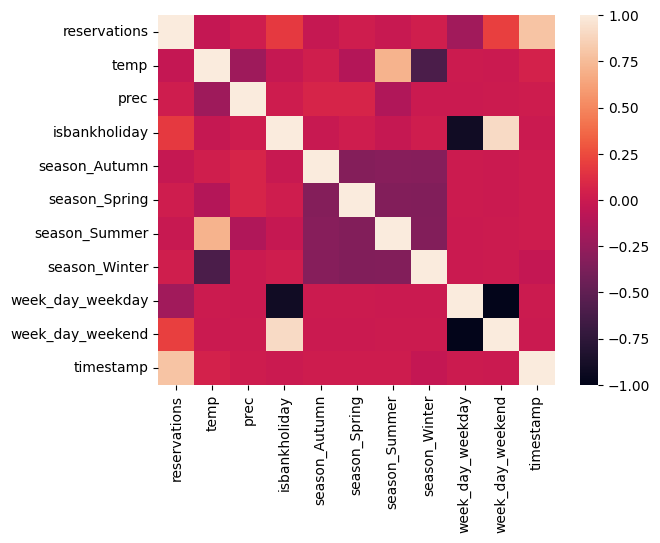

In [246]:
sns.heatmap(corr)

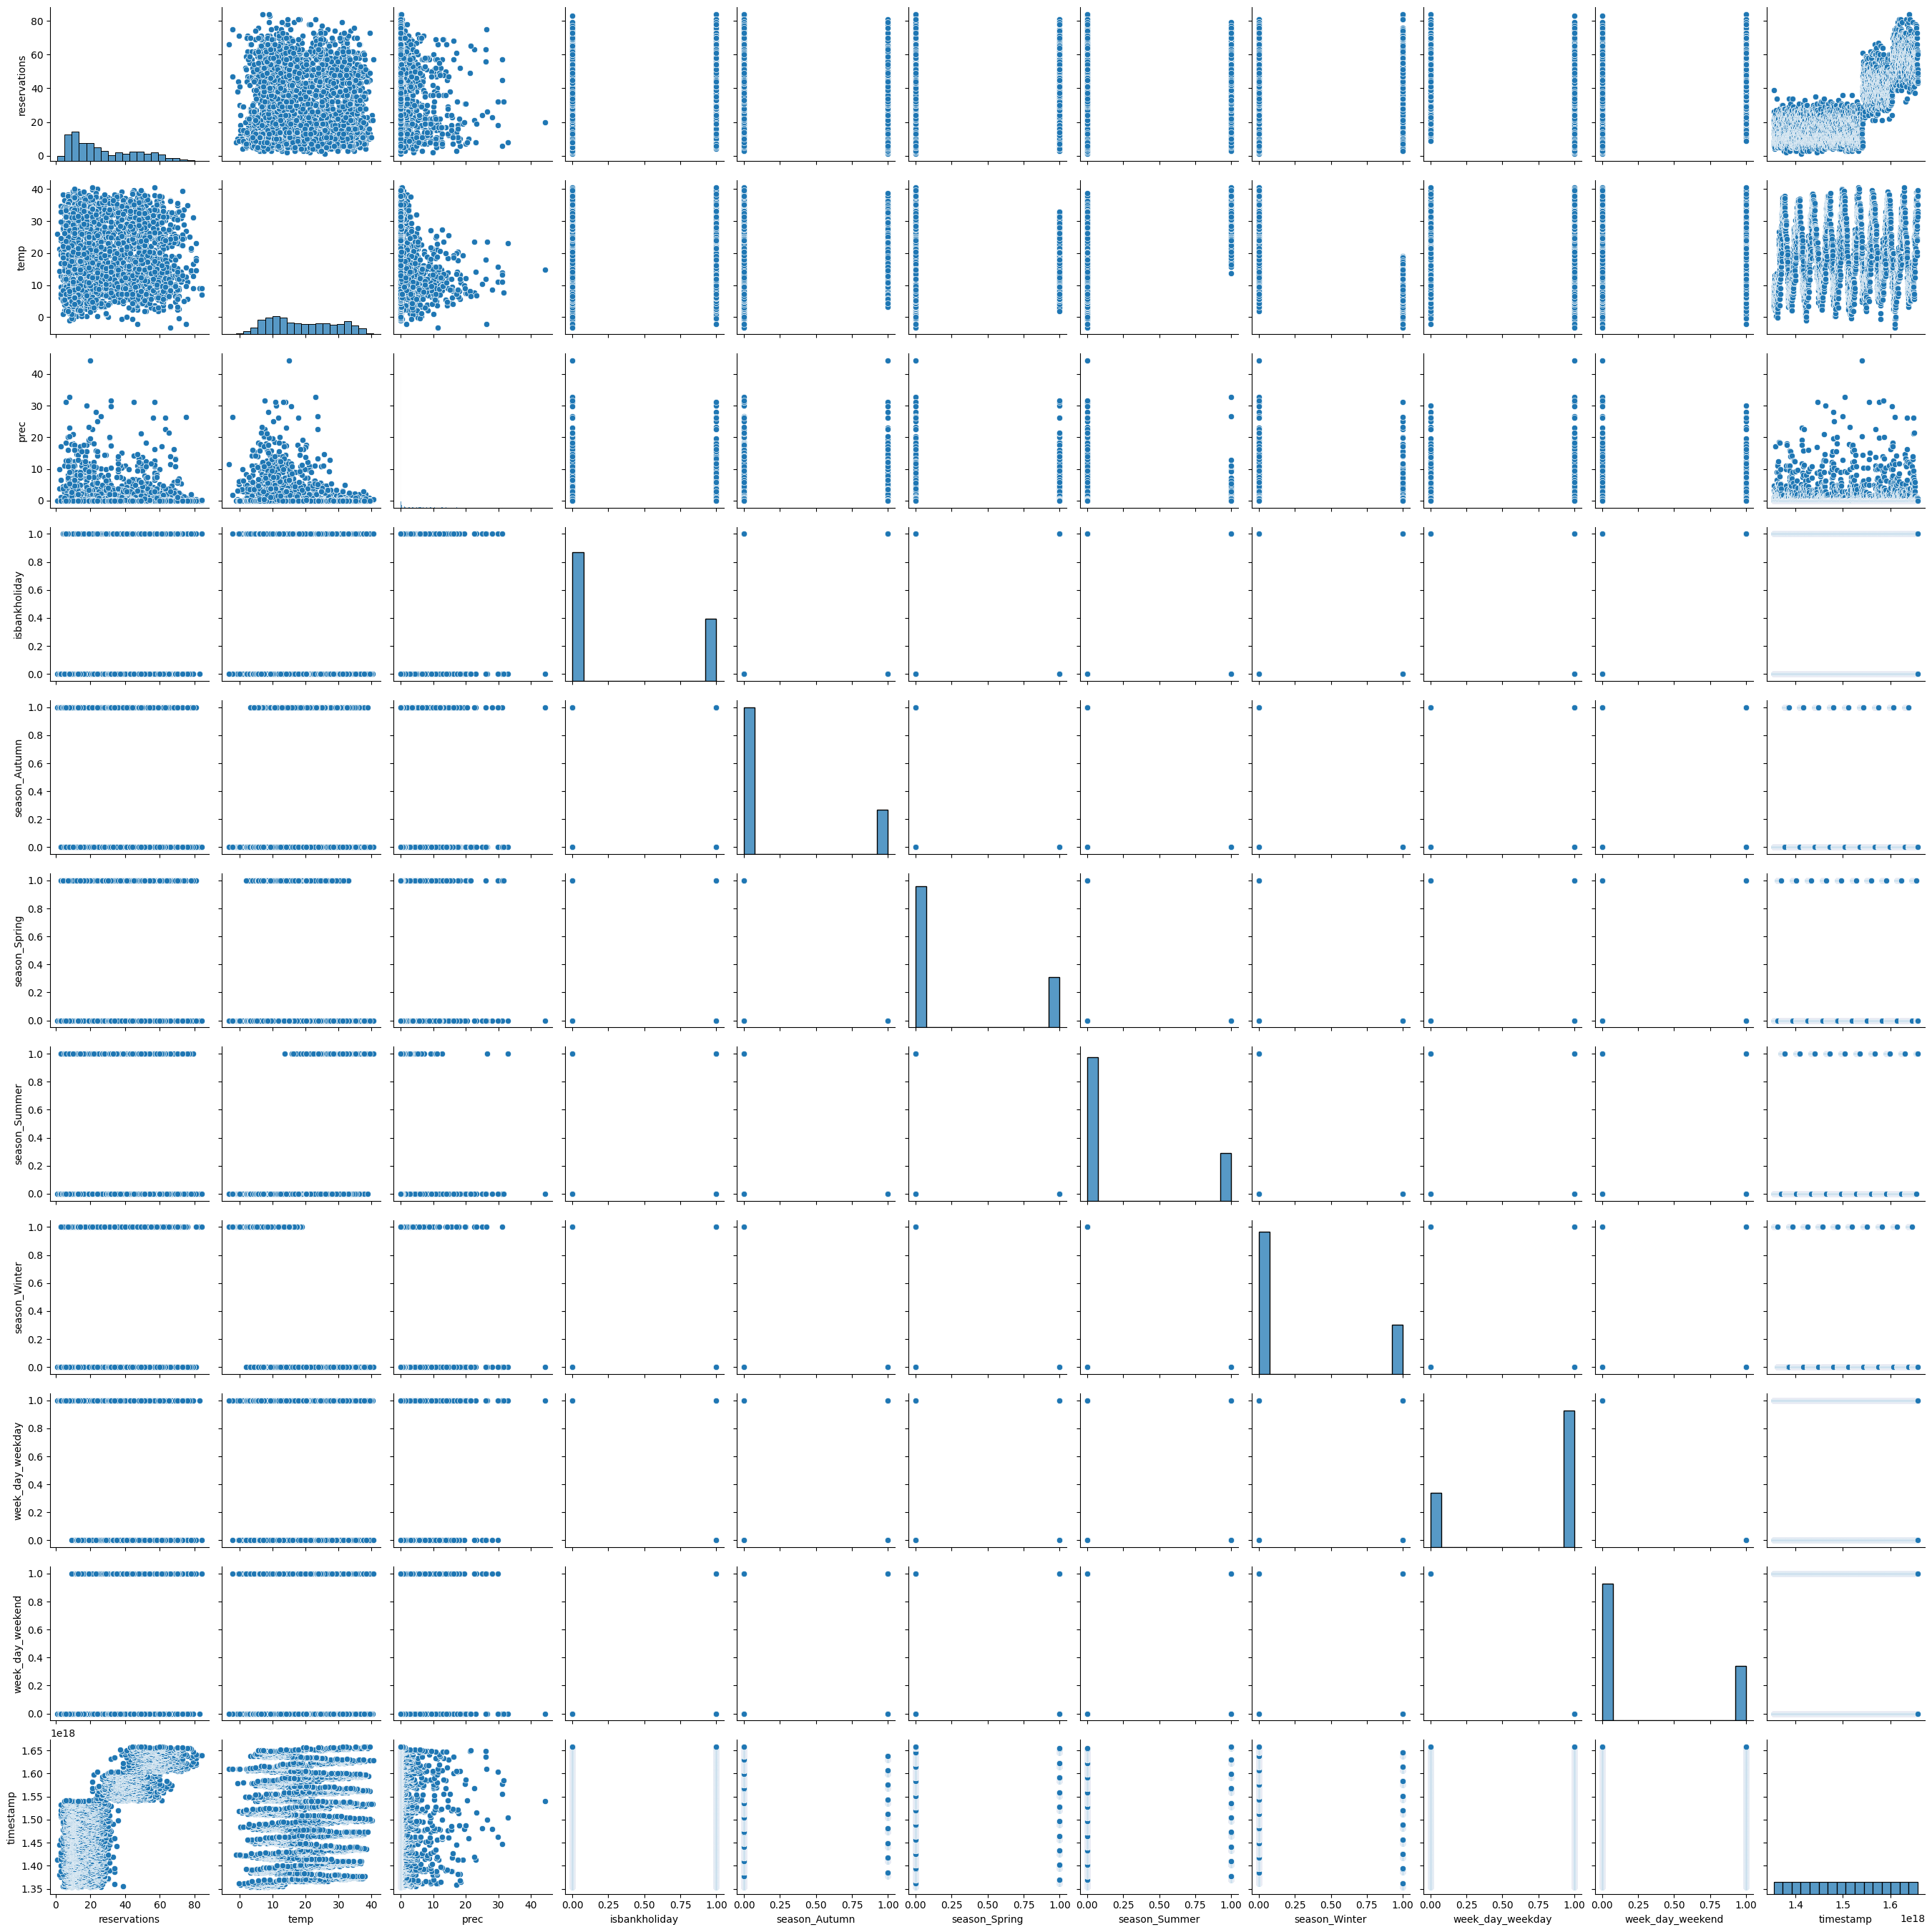

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(reser_df)

In [248]:
reser_df.head()

,date,reservations,temp,prec,isbankholiday,season_Autumn,season_Spring,season_Summer,season_Winter,week_day_weekday,week_day_weekend,timestamp
0,2012-12-01,26,3.3,0.0,1,0,0,0,1,0,1,1354320000000000000
1,2012-12-02,20,5.7,0.0,1,0,0,0,1,0,1,1354406400000000000
2,2012-12-03,9,7.3,0.0,0,0,0,0,1,1,0,1354492800000000000
3,2012-12-04,6,8.5,0.0,0,0,0,0,1,1,0,1354579200000000000
4,2012-12-05,13,6.0,0.0,0,0,0,0,1,1,0,1354665600000000000


In [249]:
reser_df.head()

,date,reservations,temp,prec,isbankholiday,season_Autumn,season_Spring,season_Summer,season_Winter,week_day_weekday,week_day_weekend,timestamp
0,2012-12-01,26,3.3,0.0,1,0,0,0,1,0,1,1354320000000000000
1,2012-12-02,20,5.7,0.0,1,0,0,0,1,0,1,1354406400000000000
2,2012-12-03,9,7.3,0.0,0,0,0,0,1,1,0,1354492800000000000
3,2012-12-04,6,8.5,0.0,0,0,0,0,1,1,0,1354579200000000000
4,2012-12-05,13,6.0,0.0,0,0,0,0,1,1,0,1354665600000000000


In [250]:
#Definimos las variables que queremos pasarle al model independiente y dependiente 


x = reser_df.iloc[:,2:]
y = reser_df['reservations']

In [251]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.2,random_state = 42)

In [252]:
#Normalización 

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train_norm = sc_X.fit_transform(x_train)
x_test_nom = sc_X.transform(x_test)


In [253]:
from sklearn.linear_model import LinearRegression

rl = LinearRegression()
rl.fit(x_train_norm,y_train)

LinearRegression()

In [254]:
rl

LinearRegression()

In [255]:
rl.coef_

array([-1.50929935, -0.03961578, -0.24002653, -0.44504508, -0.02706298,
        0.33283958,  0.12355066, -1.9756411 ,  1.9756411 , 15.17065503])

In [256]:
#Cuanto mas cercano a 1 mas chachi

rl.score(x_train_norm,y_train)

0.6786071522764131

In [257]:
y_pred = rl.predict(x_test_nom)

In [258]:
from sklearn.metrics import classification_report 
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#print(classification_report)

MAE: 8.740506857854765
MSE: 115.31266013574596
RMSE: 10.738373253698438


In [259]:
intercept = rl.intercept_
features = pd.DataFrame(rl.coef_, x_train.columns, columns=['coefficient'])
#features.coefficient = features.coefficient.abs()
print(rl.intercept_)
features.sort_values('coefficient', ascending=False)

27.882520469918145


,coefficient
timestamp,15.170655
week_day_weekend,1.975641
season_Summer,0.332840
season_Winter,0.123551
season_Spring,-0.027063
prec,-0.039616
isbankholiday,-0.240027
season_Autumn,-0.445045
temp,-1.509299
week_day_weekday,-1.975641


In [260]:
rl.coef_

array([-1.50929935, -0.03961578, -0.24002653, -0.44504508, -0.02706298,
        0.33283958,  0.12355066, -1.9756411 ,  1.9756411 , 15.17065503])

In [263]:
reser_df.head(3)

,date,reservations,temp,prec,isbankholiday,season_Autumn,season_Spring,season_Summer,season_Winter,week_day_weekday,week_day_weekend,timestamp
0,2012-12-01,26,3.3,0.0,1,0,0,0,1,0,1,1354320000000000000
1,2012-12-02,20,5.7,0.0,1,0,0,0,1,0,1,1354406400000000000
2,2012-12-03,9,7.3,0.0,0,0,0,0,1,1,0,1354492800000000000


In [264]:
#Definimos las variables que queremos pasarle al model independiente y dependiente 


x_sin_prec = reser_df.drop(["prec","date", "reservations"] , axis = 1)
y_sin_prec = reser_df['reservations']

In [267]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_sin_prec, y_sin_prec, test_size=0.2,random_state = 42)

In [268]:
#Normalización 

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train_norm = sc_X.fit_transform(x_train)
x_test_nom = sc_X.transform(x_test)


In [269]:
from sklearn.linear_model import LinearRegression

rl = LinearRegression()
rl.fit(x_train_norm,y_train)

LinearRegression()

In [270]:
#Cuanto mas cercano a 1 mas chachi

rl.score(x_train_norm,y_train)

0.6786031151686511

In [271]:
y_pred = rl.predict(x_test_nom)

In [272]:
from sklearn.metrics import classification_report 
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 8.741613188414963
MSE: 115.35560959203868
RMSE: 10.740372879562361


In [273]:
git push

SyntaxError: invalid syntax (4238376967.py, line 1)